<a href="https://colab.research.google.com/github/OlegV12/Neural/blob/Lesson_7/Lesson_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Практическое задание
Сделайте краткий обзор любой статьи посвященной тому или иному алгоритму для object detection, который не рассматривался на уроке. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?
Запустите детектор (ssdMobile_v2 или faster_rcnn, или любой другой детектор) для своей картинки и попробуйте найти 10 объектов, 100 объектов.


Оригинальная научная статья по YOLO - https://arxiv.org/pdf/1506.02640.pdf

В статье алгоритм YOLO (you look only once) в основоном сравнивается с R-CNN. R-CNN заключается в нескольких последовательных действиях (своего рода пайплайн) - разбиение изображения на части, предсказание классификатора на этих частях, постобработка предсказаний. Что в свою очередь затрудняет оптимизацию, т.к. оптимизировать нужно каждый этап. YOLO в свою очередь сразу предсказыает границы объектов и их классы на всем изображении. Что позваляет ей обладать рядом приемуществ:
-скорость (обучение на всем изображении и предсказание с одного "прохода"
-предсказание с учетом контекста (в отличие от R-CNN и скользящего окна)т.е. нейросеть видит всю картинку целиком
Ряд минусов указанных в статье:
-сеть уступает самым продвинутым решениям в "accuracy"
-при высокой скорости работы, не достаточно плохо определяет малые объекты.
-плохо определяет близко находящиеся мелкие объекты например стаю птиц.
Несмотря ны вышеуказанные недостатки, авторы заявляют достаточную для детектирования объектов в реальном времени скорость работы.


In [1]:
# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.8.0
The following GPU devices are available: 


In [25]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [4]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [5]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [28]:
def run_detector(detector, path, boxes_num=10):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], max_boxes=boxes_num)

  display_image(image_with_boxes)

In [9]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [29]:
img1 = 'https://docs.google.com/uc?export=download&id=17GdTRCD1gxu0qwtJq1gBhWatEjKR0_C_'

Image downloaded to /tmp/tmprcpvnses.jpg.


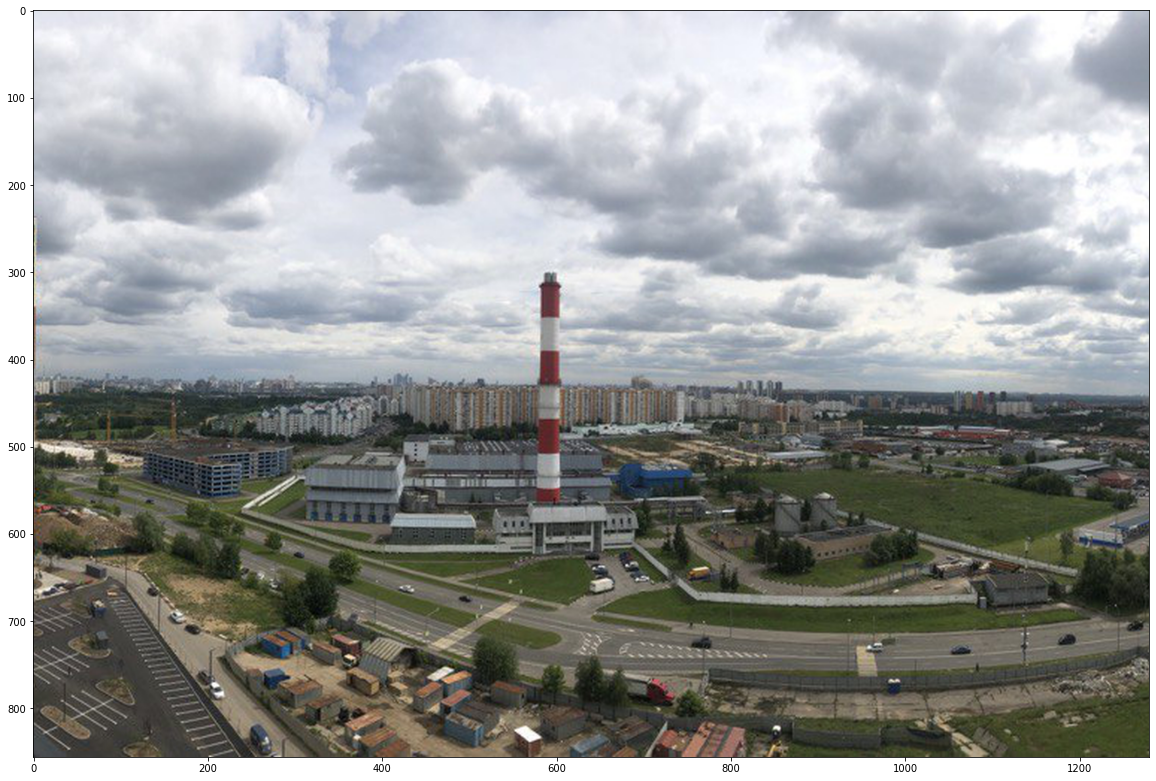

In [30]:
downloaded_image1_path = download_and_resize_image(img1, 1280, 856, True)

Found 100 objects.
Inference time:  38.53547644615173


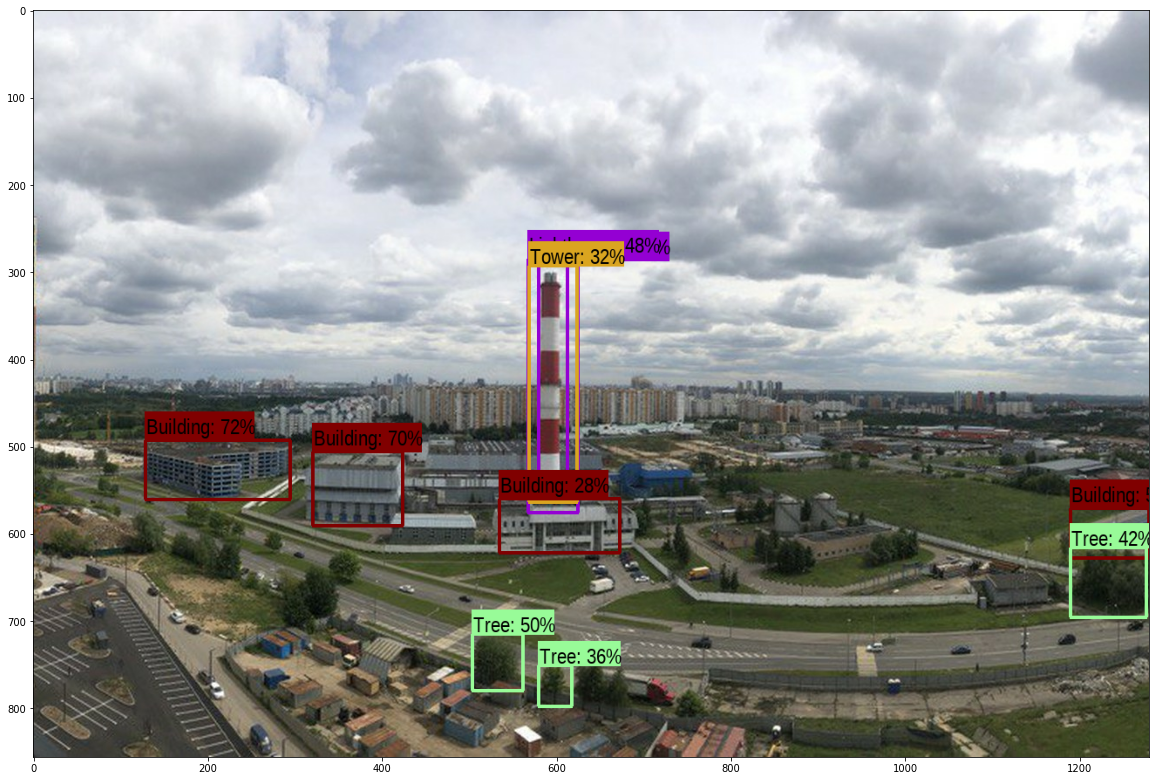

In [31]:
run_detector(detector, downloaded_image1_path)

Found 100 objects.
Inference time:  28.53595232963562


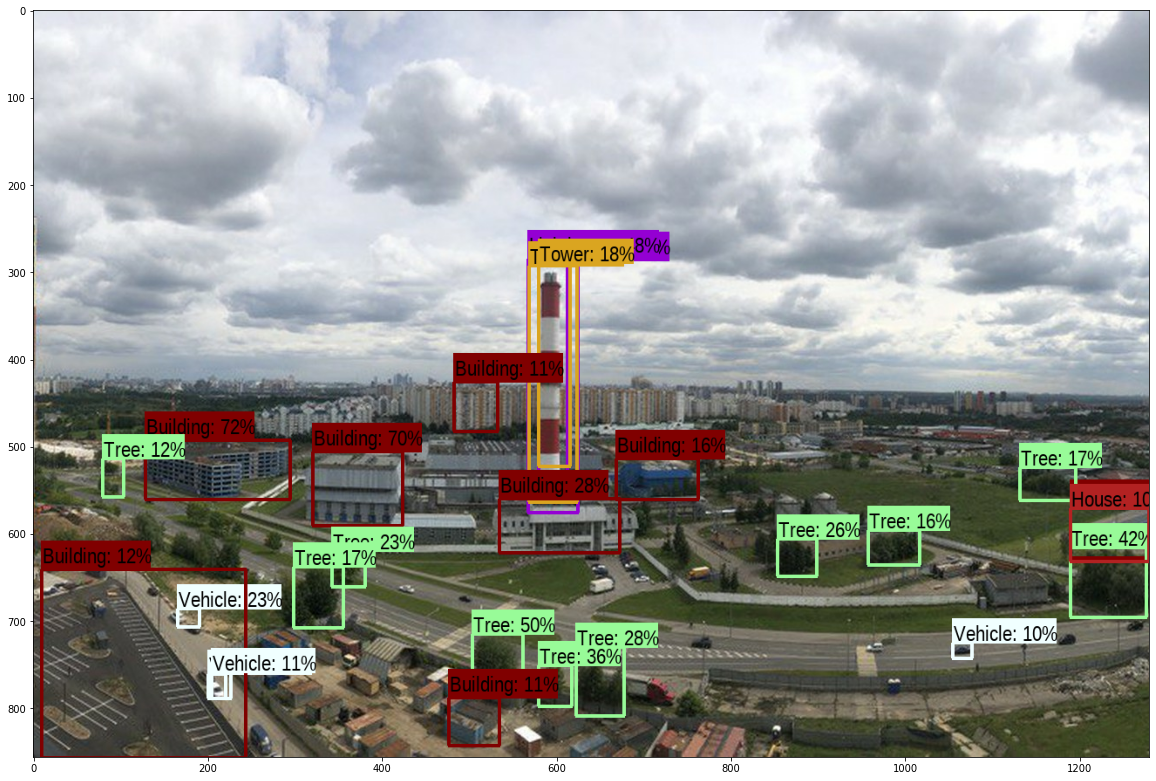

In [32]:
run_detector(detector, downloaded_image1_path, 100)

In [33]:
img2 = 'https://docs.google.com/uc?export=download&id=1INCB-6v_IQEHiTe-pl0fYIwOggrI_E5e'

Image downloaded to /tmp/tmpigqya_gu.jpg.


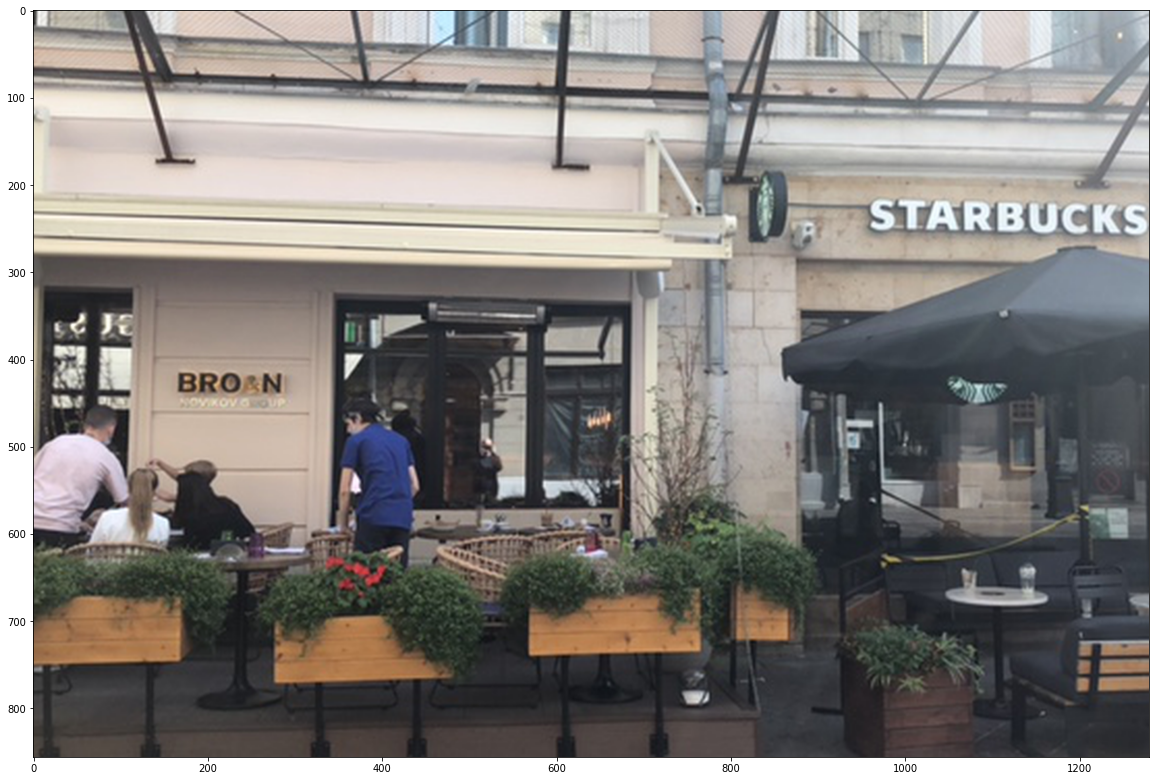

In [34]:
downloaded_image2_path = download_and_resize_image(img2, 1280, 856, True)

Found 100 objects.
Inference time:  28.700827836990356


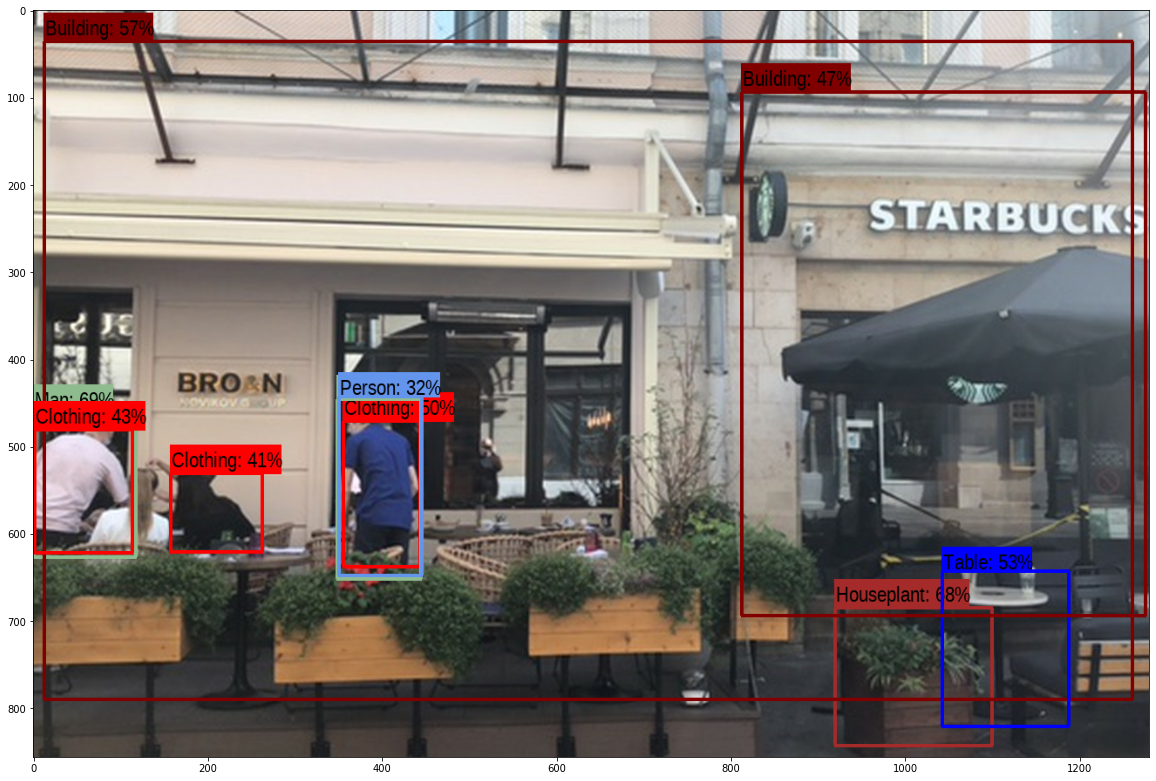

In [35]:
run_detector(detector, downloaded_image2_path)

Found 100 objects.
Inference time:  28.65623164176941


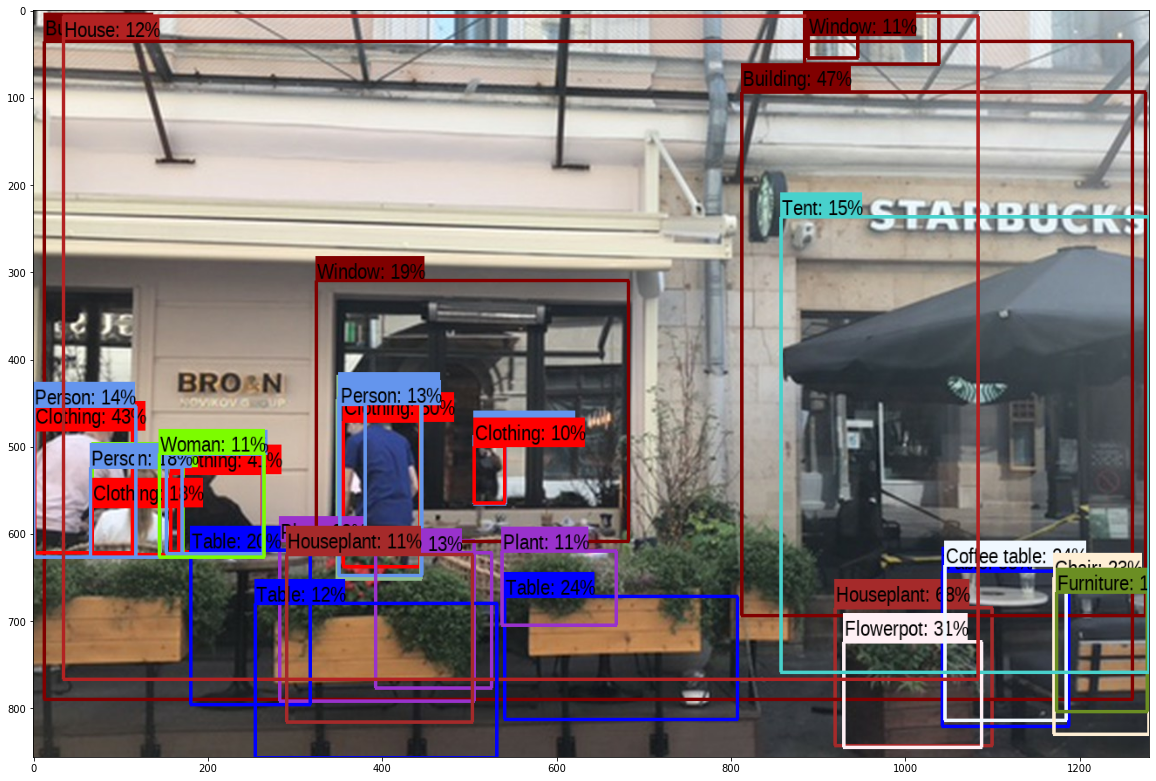

In [36]:
run_detector(detector, downloaded_image2_path, 100)